# import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy, tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
plt.rcParams['figure.figsize'] = (12,8)
default_plot_color = '#00bfbf'

# Data Overview

In [ ]:
df = pd.read_csv("fake-news-data.csv")

In [4]:
df.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


## ration between the fake and factual

<Axes: xlabel='fake_or_factual'>

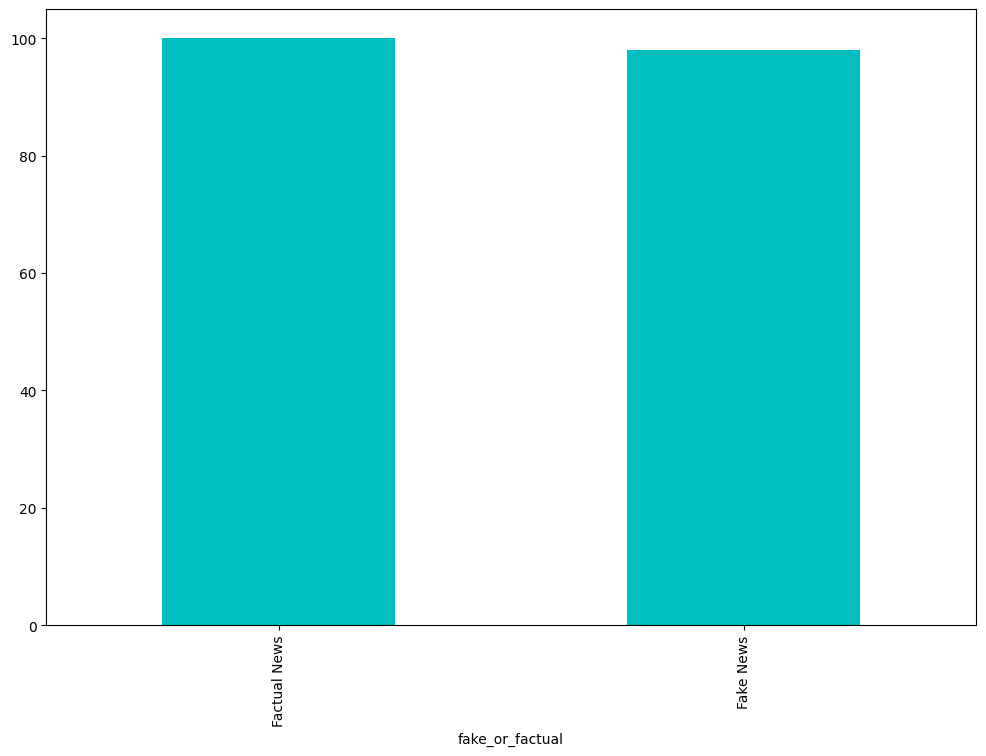

In [6]:
df['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_color)

# POS tagging

## load the model

In [7]:
nlp = spacy.load("en_core_web_sm")

## separate the news and list them

In [8]:
fake_news = df[df['fake_or_factual'] == 'Fake News']
fact_news = df[df['fake_or_factual'] == 'Factual News']

In [9]:
fake_spacydocs = list(nlp.pipe(fake_news['text']))
fact_spacydocs = list(nlp.pipe(fact_news['text']))

## extract the tags

In [10]:
def extract_token_tags(doc:spacy.tokens.Doc):
    return[(i.text, i.ent_type_, i.pos_) for i in doc]

In [11]:
fake_tag_df = []
fact_tag_df = []
columns = ['token', 'ner_tag', 'pos_tag']

In [12]:
for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tag_df.append(tags)

In [13]:
fake_tag_df = pd.concat(fake_tag_df)

In [14]:
for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tag_df.append(tags)

In [15]:
fact_tag_df = pd.concat(fact_tag_df)

In [16]:
fake_tag_df.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


## grouping by the tokens and their most counts

In [17]:
pos_counts_fake = fake_tag_df.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [18]:
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [19]:
pos_counts_fact = fact_tag_df.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [20]:
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


## grouping by the pos_tag

In [21]:
pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

In [22]:
pos_counts_fact.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: token, dtype: int64

## get the NOUNS and their counts

In [23]:
pos_counts_fake[pos_counts_fake.pos_tag == 'NOUN'][:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
8011,year,NOUN,44
3138,campaign,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [24]:
pos_counts_fact[pos_counts_fact.pos_tag == 'NOUN'][:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
2497,campaign,NOUN,42


# Named Entity Recognition

## separate the fake and factual

In [25]:
top_entities_fake = fake_tag_df[fake_tag_df['ner_tag'] != ''].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
top_entities_fact = fact_tag_df[fact_tag_df['ner_tag'] != ''].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

## plot the entities

In [26]:
ner_palette = {
    'ORG' : sns.color_palette('Set2').as_hex()[0],
    'GPE' : sns.color_palette('Set2').as_hex()[1],
    'NORP': sns.color_palette('Set2').as_hex()[2],
    'PERSON': sns.color_palette('Set2').as_hex()[3],
    'DATE': sns.color_palette('Set2').as_hex()[4],
    'CARDINAL': sns.color_palette('Set2').as_hex()[5],
    'PERCENT': sns.color_palette('Set2').as_hex()[6]
}

### fake news entities

C:\Users\Mohammed237\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Mohammed237\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Mohammed237\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarni

[Text(0.5, 1.0, 'Most common named entities in fake news')]

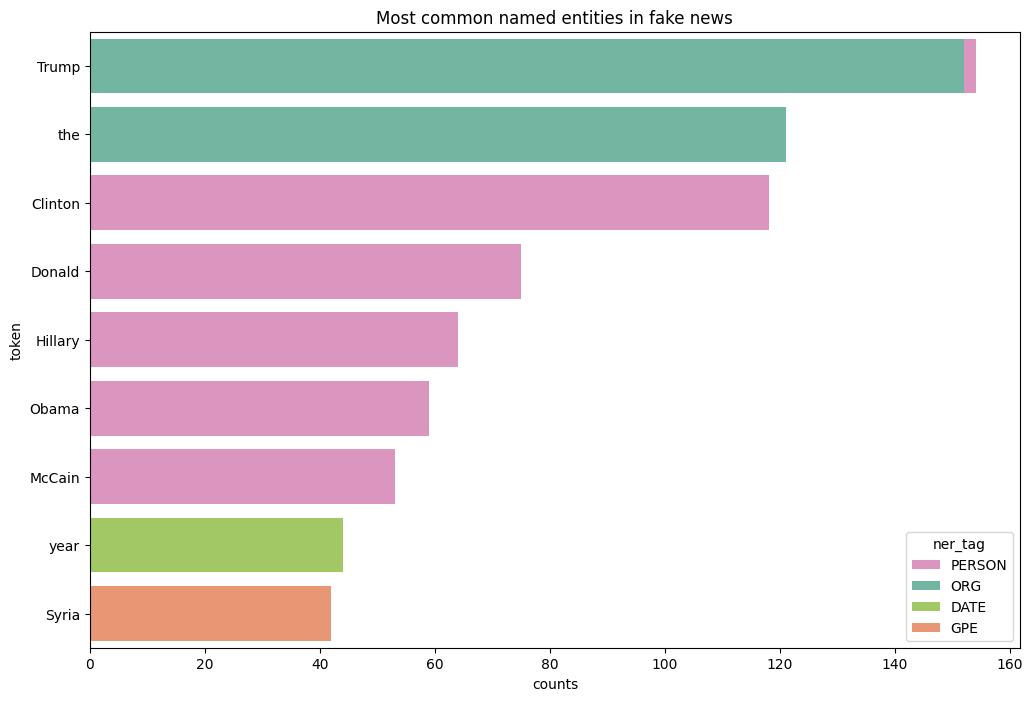

In [27]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette= ner_palette,
    data = top_entities_fake[:10],
    dodge = False,
).set(title="Most common named entities in fake news")

### fact entities

C:\Users\Mohammed237\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Mohammed237\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Mohammed237\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarni

[Text(0.5, 1.0, 'Most common named entities in fact news')]

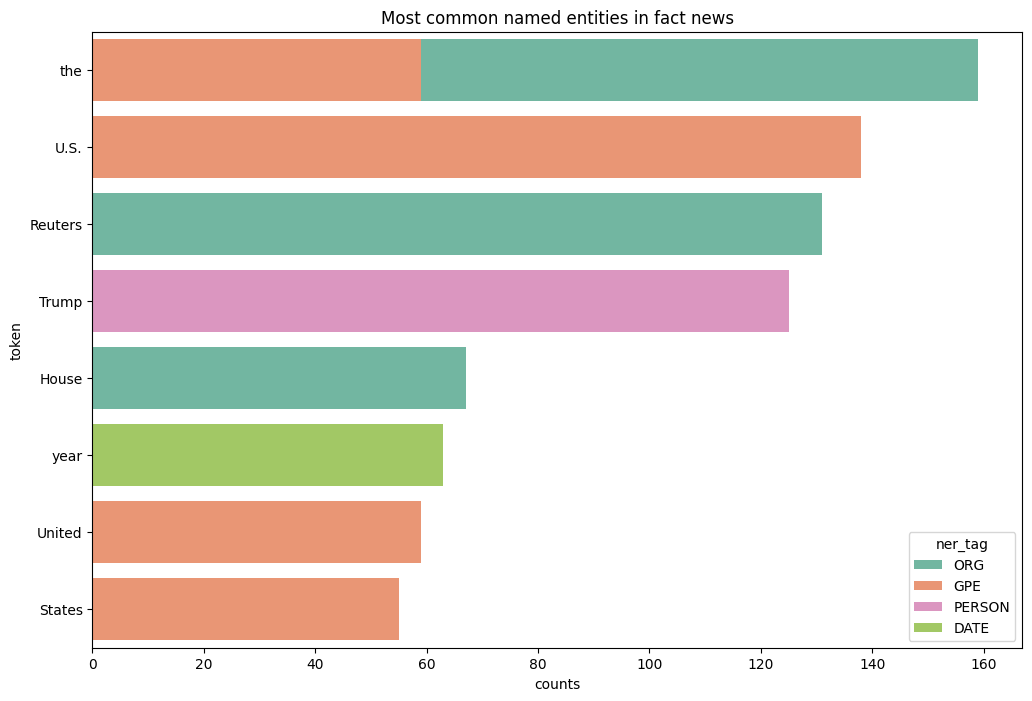

In [28]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette= ner_palette,
    data = top_entities_fact[:10],
    dodge = False,
).set(title="Most common named entities in fact news")

# Text preprocessing

In [29]:
df.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


## remove ^ from the text

In [30]:
df['text_clean'] = df.apply(lambda x: re.sub(r'^[^-]*-\s', '', x['text']), axis=1)

In [31]:
df.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,There are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,Buried in Trump s bonkers interview with New Y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"Women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,U.S. Defense Secretary Jim Mattis said on Mond...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,Northern Ireland s political parties are rapid...


## Lowercase the text

In [32]:
df['text_clean'] = df['text_clean'].str.lower()

## remove punctuation

In [33]:
df['text_clean'] = df.apply(lambda x: re.sub(r'[^\w\s]', '', x['text_clean']), axis=1)

In [34]:
df.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,there are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make up over 50 percent of this country ...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,us defense secretary jim mattis said on monday...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...


## remove stopwords

In [35]:
en_stopwords = stopwords.words('english')
print(en_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [36]:
df['text_clean'] = df['text_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in en_stopwords))

In [37]:
df.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,two small problems analogy susan jesus muslim ...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried trump bonkers interview new york times ...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make 50 percent country grossly underrep...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,us defense secretary jim mattis said monday ru...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland political parties rapidly run...


## Tokenization

In [38]:
df.text_clean = df.apply(lambda x: word_tokenize(x['text_clean']), axis=1)

In [39]:
lemmatizer = WordNetLemmatizer()
df['text_clean'] = df['text_clean'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [40]:
df.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [41]:
tokens_clean = sum(df['text_clean'], [])

## n-grams

In [42]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts())
print(unigrams[:10])

(trump,)         580
(said,)          580
(u,)             277
(state,)         275
(president,)     259
(would,)         226
(one,)           160
(clinton,)       141
(year,)          139
(republican,)    137
Name: count, dtype: int64


In [43]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts())
print(bigrams[:10])

(donald, trump)            113
(united, state)             84
(white, house)              74
(president, donald)         47
(hillary, clinton)          39
(new, york)                 33
(supreme, court)            30
(image, via)                29
(trump, administration)     26
(official, said)            26
Name: count, dtype: int64


# Sentiment Analysis

to see if the classification of the sentiment differ in the news article or not 

In [44]:
vader_sentiment = SentimentIntensityAnalyzer()

In [45]:
df['vader_sentiment_score'] = df['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [46]:
df.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


## make ranges to group the text

In [47]:
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

In [48]:
df['vader_sentiment_label'] = pd.cut(df['vader_sentiment_score'], bins, labels=names)

In [49]:
df.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


## plot the labels ratio

<Axes: xlabel='vader_sentiment_label'>

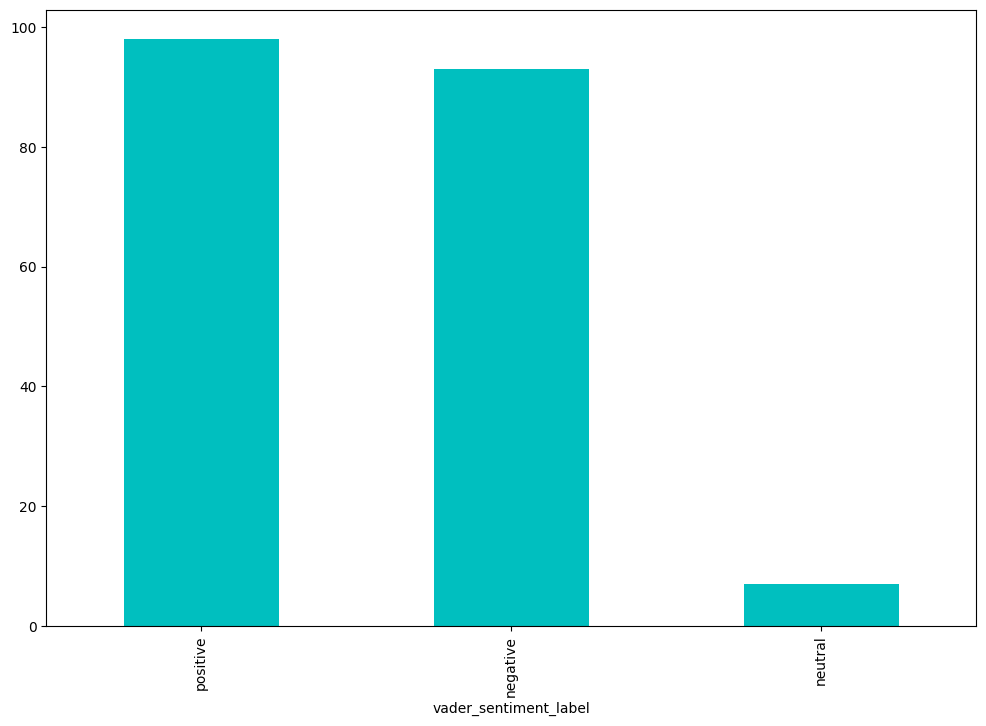

In [50]:
df['vader_sentiment_label'].value_counts().plot.bar(color= default_plot_color)

C:\Users\Mohammed237\AppData\Local\Temp\ipykernel_8744\2647739285.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(
C:\Users\Mohammed237\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Mohammed237\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_

[Text(0.5, 1.0, 'sentiment by news type')]

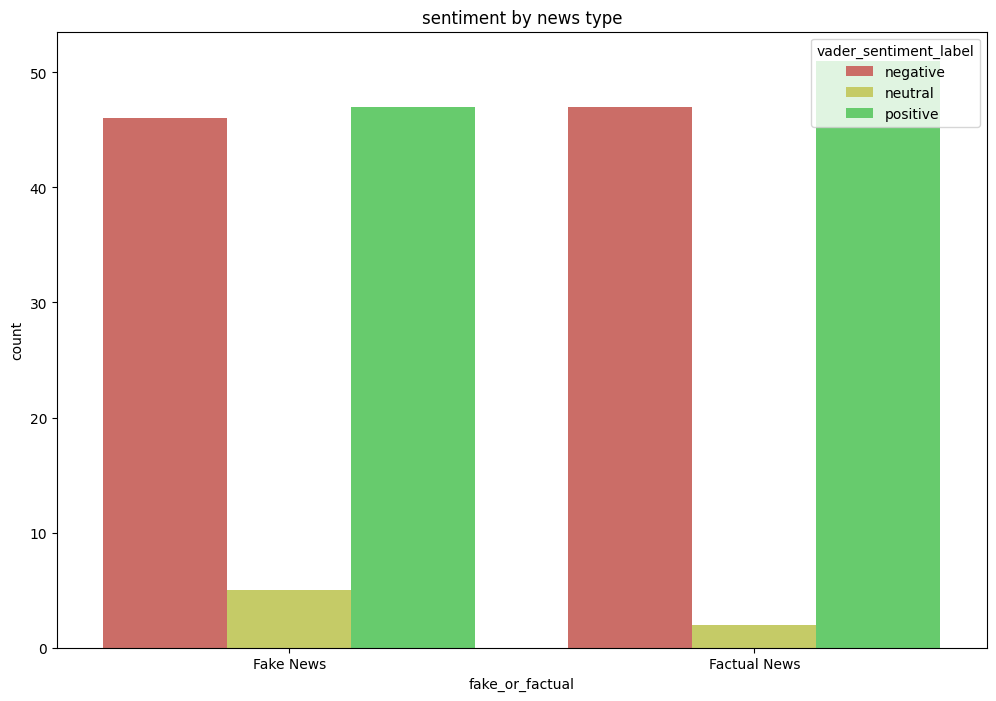

In [51]:
sns.countplot(
    x='fake_or_factual',
    hue=df['vader_sentiment_label'],
    palette=sns.color_palette('hls'),
    data=df
).set(title="sentiment by news type")

# Classification Model

In [52]:
df.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [53]:
x = [','.join(map(str, i)) for i in df['text_clean']]

In [54]:
y = df['fake_or_factual']

## vectorize the text

In [55]:
countvec = CountVectorizer()

In [56]:
countvec_fit = countvec.fit_transform(x)

In [57]:
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns=countvec.get_feature_names_out())

In [58]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, y, test_size=.3, random_state=42)

## logistic regression

In [59]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [60]:
y_pred = lr.predict(X_test)

In [61]:
accuracy_score(y_pred, y_test)

0.8666666666666667

In [62]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

Factual News       0.88      0.88      0.88        32
   Fake News       0.86      0.86      0.86        28

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



## SVM

In [63]:
svm = SGDClassifier()
svm.fit(X_train, y_train)

SGDClassifier()

In [64]:
y_pred = lr.predict(X_test)

In [65]:
accuracy_score(y_pred, y_test)

0.8666666666666667

In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

Factual News       0.88      0.88      0.88        32
   Fake News       0.86      0.86      0.86        28

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60

